In [34]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import Rbf, interp1d, griddata
import time
from matplotlib import rc
rc('text', usetex=False)
plt.rcParams.update({'font.size': 8})

In [11]:
# Parameters
l = 1e5 # Number of proteins
K = 1e3 # 
n = 2. #
Kn = K**n # 
_b_ = 1. # mean = 1/p burst production
_N0_ = 1e2 # Replication of plasmid
gamma = 0 # Protein degradation
mu0 = 1 # Max. growth rate

In [ ]:
df = pd.read_json('fluo_tracking_1000-2.json')

In [ ]:
cell_idxs = ['%d'%idx for idx in np.arange(997)]
maxr = np.array([row['rad_edge'] for idx,row in df.iterrows()])
r = [[row['rad_edge'] - row[cell_idx]['rad'] for cell_idx in cell_idxs] for idx,row in df.iterrows()]
R = [[row[cell_idx]['rad'] for cell_idx in cell_idxs] for idx,row in df.iterrows()]
gr = [[row[cell_idx]['gr'] for cell_idx in cell_idxs] for idx,row in df.iterrows()]
vol = [[row[cell_idx]['vol'] for cell_idx in cell_idxs] for idx,row in df.iterrows()]
r = np.array(r)
R = np.array(R)
gr = np.array(gr)
vol = np.array(vol)

#plt.plot(maxr-r)
#plt.figure()
#plt.plot(vol[:200])
#plt.show()
#plt.plot(gr)
#plt.show()

In [ ]:
plt.plot(gr[:,10]);
import pandas as pd
df = pd.DataFrame(gr)
df.head()
df = df.ewm(alpha=0.1).mean()
df.head()

plt.plot(df[10].values)

plt.figure()
plt.plot(vol[:,10])

In [12]:
ip1 = []
ip2 = []
ip3 = []
#p1_list = []
#p2_list = []
#p3_list = []
#N0_list = []
#t_list = []
iters = 100
maxt = 50
T = np.linspace(0, maxt, 500)
for it in range(iters):
    print('------------')
    print('Iteration %d'%it)
    start = time.time()
    # Initial conditions
    p1 = [1e3]
    p2 = [0]
    p3 = [0]
    N0 = [_N0_]
    t = [0]
    mu = [mu0]
    i = 0
    dt = 0.05 # Cellmodeller dt
    # Time loop
    while(t[i]<maxt):
      # Model the motion of cells and its effect on growth rate
      #nextmu = df[10].values[int(t[i]//dt)] #gr[int(t[i]//dt), 0]
      mu.append(mu0)

      # Protein numbers and plasmid number
      p1i = p1[i]
      p2i = p2[i]
      p3i = p3[i]
      N0i = N0[i]
    
      # Check for cell division 
      volume = 1 #vol[int(t[i]//dt),0]
      '''
      if i>0:
          volume_prev = vol[int(t[i-1]//dt),0]
          if volume-volume_prev < -volume_prev*0.4:
            print('Dividing cell')
            print(volume, volume_prev)
            # Divide proteins and plasmid
            frac = volume / volume_prev
            p1i = int(p1i * frac)
            p2i = int(p2i * frac)
            p3i = int(p3i * frac)
            N0i = int(N0i * frac)
      '''
            
      # Solve the quadratic to find free repressor concentrations **n
      p1n = p1i**n
      p2n = p2i**n
      p3n = p3i**n
      p1freen = p1n - Kn - 2*N0i + np.sqrt( Kn*Kn + (2*N0i-p1n)**2 + 2*Kn*(2*N0i+p1n) )
      p2freen = p2n - Kn - 2*N0i + np.sqrt( Kn*Kn + (2*N0i-p2n)**2 + 2*Kn*(2*N0i+p2n) )
      p3freen = p3n - Kn - 2*N0i + np.sqrt( Kn*Kn + (2*N0i-p3n)**2 + 2*Kn*(2*N0i+p3n) )

      # Reaction propensities
      # Production of repressors
      a1_1 = l * N0i * Kn / (Kn + p3freen)
      a1_2 = l * N0i * Kn / (Kn + p1freen)
      a1_3 = l * N0i * Kn / (Kn + p2freen)
      # Degradation of repressors
      a2_1 = (mu[i] + gamma) * p1i
      a2_2 = (mu[i] + gamma) * p2i
      a2_3 = (mu[i] + gamma) * p3i
      # Replication of plasmid
      a3 = _N0_ 
      # Degradation of plasmid
      a4 = mu[i] * N0i

      # Total of propensities
      A = a1_1 + a1_2 + a1_3 + a2_1 + a2_2 + a2_3 + a3 + a4

      # Time to next reaction
      # Scale propensities by cell volume for cell it at time t
      tau = 1/A/volume * np.log(1/np.random.random())
      t.append(t[i] + tau)

      # Random number to select next reaction
      a_i = np.random.random() * A

      # Random number for protein count update on production
      b = _b_ #np.random.geometric(1/_b_) # Note _b_ = mean = 1/p

      # Update protein and plasmid numbers according to reaction selected
      if a_i < a1_1:
        # Production of repressor 1
        p1.append(p1i+b)
        p2.append(p2i)
        p3.append(p3i)
        N0.append(N0i)
      elif a_i < a1_1 + a1_2:
        # Production of repressor 2
        p1.append(p1i)
        p2.append(p2i+b)
        p3.append(p3i)
        N0.append(N0i)
      elif a_i < a1_1 + a1_2 + a1_3:
        # Production of repressor 3
        p1.append(p1i)
        p2.append(p2i)
        p3.append(p3i+b)
        N0.append(N0i)
      elif a_i < a1_1 + a1_2 + a1_3 + a2_1:
        # Degradation of repressor 1
        p1.append(p1i-1)
        p2.append(p2i)
        p3.append(p3i)
        N0.append(N0i)
      elif a_i < a1_1 + a1_2 + a1_3 + a2_1 + a2_2:
        # Degradation of repressor 2
        p1.append(p1i)
        p2.append(p2i-1)
        p3.append(p3i)
        N0.append(N0i)
      elif a_i < a1_1 + a1_2 + a1_3 + a2_1 + a2_2 + a2_3:
        # Degradation of repressor 3
        p1.append(p1i)
        p2.append(p2i)
        p3.append(p3i-1)
        N0.append(N0i)
      elif a_i < a1_1 + a1_2 + a1_3 + a2_1 + a2_2 + a2_3 + a3:
        # Replication of plasmid
        p1.append(p1i)
        p2.append(p2i)
        p3.append(p3i)
        N0.append(N0i+1)
      else:
        # Degradation of plasmid
        p1.append(p1i)
        p2.append(p2i)
        p3.append(p3i)
        N0.append(N0i-1)
      i += 1
    end = time.time()
    print('Elapsed time ', end-start)
    ip1.append(interp1d(t, p1)(T))
    ip2.append(interp1d(t, p2)(T))
    ip3.append(interp1d(t, p3)(T))
    #p1_list.append(p1)
    #p2_list.append(p2)
    #p3_list.append(p3)
    #N0_list.append(N0)
    #t_list.append(t)

ip1 = np.array(ip1)
ip2 = np.array(ip2)
ip3 = np.array(ip3)

------------
Iteration 0
Elapsed time  92.17325496673584
------------
Iteration 1
Elapsed time  102.00142216682434
------------
Iteration 2
Elapsed time  99.15577912330627
------------
Iteration 3
Elapsed time  105.07676696777344
------------
Iteration 4
Elapsed time  99.15247297286987
------------
Iteration 5
Elapsed time  93.95767903327942
------------
Iteration 6
Elapsed time  93.97390484809875
------------
Iteration 7
Elapsed time  94.08363628387451
------------
Iteration 8
Elapsed time  89.6304440498352
------------
Iteration 9
Elapsed time  93.75820517539978
------------
Iteration 10
Elapsed time  91.44810605049133
------------
Iteration 11
Elapsed time  100.13905096054077
------------
Iteration 12
Elapsed time  90.56778597831726
------------
Iteration 13
Elapsed time  96.18399119377136
------------
Iteration 14
Elapsed time  85.65429472923279
------------
Iteration 15
Elapsed time  93.61959767341614
------------
Iteration 16
Elapsed time  110.84336590766907
------------
Iteratio

In [13]:
np.save('ip1_l=1e5.npy', ip1)
np.save('ip2_l=1e5.npy', ip2)
np.save('ip3_l=1e5.npy', ip3)

In [14]:
ip1 = np.load('ip1_l=1e5.npy')
ip2 = np.load('ip2_l=1e5.npy')
ip3 = np.load('ip3_l=1e5.npy')

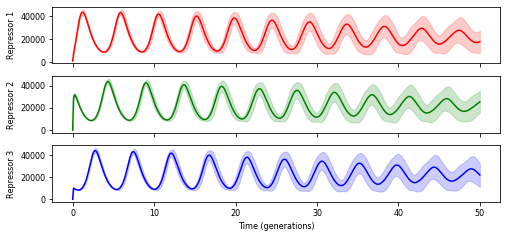

In [38]:
fig,axs = plt.subplots(3, 1, figsize=(180/25.4,85/25.4), sharex=True)
for i, (ax,col,y) in enumerate(zip(axs, ['r', 'g', 'b'], [ip1, ip2, ip3])):
    mean = np.nanmean(y, axis=0)
    std = np.nanstd(y, axis=0)
    #ax.plot(y[:,:].transpose(), 'k-', alpha=0.2)
    ax.plot(T, mean.transpose(), '-', color=col);
    ax.fill_between(T, mean-std, mean+std, color=col, alpha=0.2)
    #ax2 = ax.twinx()
    #ax2.plot(vol[:,1])
    ax.set_ylabel('Repressor %d'%(i+1))
plt.xlabel('Time (generations)')
plt.tight_layout()
plt.savefig('gillespie.png', dpi=300)

In [ ]:
plt.plot(iR.transpose())

In [ ]:
plt.imshow(ip1.transpose(), aspect='auto');

In [ ]:
nt = 100
nx = 100

points = np.stack((iT.ravel(), iR.ravel())).transpose()

ti = np.linspace(0, iT.max(), nt, endpoint=True)
ri =  np.linspace(0, iR.max(), nx, endpoint=True)
mti,mri = np.meshgrid(ti, ri)
xi = np.stack((mti.ravel(),mri.ravel())).transpose()

grid1 = griddata(points, ip1.ravel(), xi, method='linear', fill_value=0)
grid2 = griddata(points, ip2.ravel(), xi, method='linear', fill_value=0)
grid3 = griddata(points, ip3.ravel(), xi, method='linear', fill_value=0)
grid1 = grid1.reshape((nx,nt))
grid2 = grid2.reshape((nx,nt))
grid3 = grid3.reshape((nx,nt))

# Stack to get 3 channel normalized image
kymo = np.stack((grid1/np.nanmax(grid1), grid2/np.nanmax(grid2), grid3/np.nanmax(grid3))).transpose()

In [ ]:
plt.plot(iT.ravel(), iR.ravel(), '.')

In [ ]:
plt.imshow(kymo)

In [ ]:
iR.shape

In [ ]:
nt = 1000
bin_size = 20
maxr = iR.max()
nbins = int(maxr//bin_size)
ip1_mean_list = []
ip2_mean_list = []
ip3_mean_list = []
for t in range(nt):
    ip1_mean = []
    ip2_mean = []
    ip3_mean = []
    for b in range(nbins):
        idx = (iR[:,t] > b * bin_size)*(iR[:,t] <= (b+1) * bin_size)
        ip1_mean.append(np.nanmean(ip1[idx,t]))
        ip2_mean.append(np.nanmean(ip2[idx,t]))
        ip3_mean.append(np.nanmean(ip3[idx,t]))
    ip1_mean_list.append(ip1_mean)
    ip2_mean_list.append(ip2_mean)
    ip3_mean_list.append(ip3_mean)

In [ ]:
aip1_mean = np.array(ip1_mean_list)
aip2_mean = np.array(ip2_mean_list)
aip3_mean = np.array(ip3_mean_list)

kymo = np.stack((aip1_mean/np.nanmax(aip1_mean), 
                 aip2_mean/np.nanmax(aip2_mean), 
                 aip3_mean/np.nanmax(aip3_mean))).transpose()
kymo.shape

In [ ]:
plt.imshow(kymo, aspect='auto');
plt.colorbar()